In [68]:
import pandas as pd
import matplotlib
import math
import random
from matplotlib import pyplot as plt
import numpy
import geopandas as gpd
from shapely.ops import unary_union

%matplotlib inline

# avoiding Type 3 fonts in matplotlib plots
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

font = {'size'   : 20}

matplotlib.rc('font', **font)
matplotlib.rc('lines', linewidth=2.0)
matplotlib.rc('lines', markersize=8)

numpy.set_printoptions(threshold=numpy.inf)

pd.set_option('display.max_rows', 500)

In [69]:
# configure simulation
input_file = 'data/gis_incidences_nona.pkl'
gis_incidences_nona=pd.read_pickle(input_file)
number_of_simulations = 100000
a = 2
lk_identifier = (127, 233, 322) # Cham, Ammerland, Donnersbergkreis
#starting_points = ((51, 42), (135, 142), (55, 250))
#starting_points = ((351, 342), (435, 442), (355, 550))

for lk in lk_identifier:
    print(gis_incidences_nona['LK'][lk])
    print(gis_incidences_nona['geometry'][lk])

# create grid
width = 1000 #215
height = 1000 #295
grid_side = 3

# calculate starting points based on geographic coordinates
map = gis_incidences_nona
map = map.get('geometry')

for lk in lk_identifier:
    # print(gis_incidences_nona['LK'][lk])
    print(map[lk])

print(map.crs)

(sp1, sp2, sp3) = gpd.points_from_xy(x=[map[lk_identifier[0]].centroid.x], y=[map[lk_identifier[0]].centroid.y], crs="epsg:4326").to_crs('epsg:3035'), \
    gpd.points_from_xy(x=[map[lk_identifier[1]].centroid.x], y=[map[lk_identifier[1]].centroid.y], crs="epsg:4326").to_crs('epsg:3035'), \
    gpd.points_from_xy(x=[map[lk_identifier[2]].centroid.x], y=[map[lk_identifier[2]].centroid.y], crs="epsg:4326").to_crs('epsg:3035')

# we set one point anywhere in the grid and keep the relation between them for our simulation
# in this specific case we choose LK Ammerland due to the coordinates
# we need to scale the coordinates by dividing through 1000, since epsg:4326 works with metres
offset_sp2_sp1_x = math.floor((sp2.x - sp1.x) / (1000 * grid_side))
offset_sp2_sp1_y = math.floor((sp2.y - sp1.y) / (1000 * grid_side))

offset_sp2_sp3_x = math.floor((sp2.x - sp3.x) / (1000 * grid_side))
offset_sp2_sp3_y = math.floor((sp2.y - sp3.y) / (1000 * grid_side))

# choose a fitting position for the first starting point and position the others according to their real coordinates
starting_points = []
starting_points.append((410, 600))
starting_points.append((starting_points[0][0] - offset_sp2_sp1_x, starting_points[0][1] - offset_sp2_sp1_y))
starting_points.append((starting_points[0][0] - offset_sp2_sp3_x, starting_points[0][1] - offset_sp2_sp3_y))

print(starting_points)

#print(gis_incidences_nona.crs)

#gis_incidences_nona = gis_incidences_nona.to_crs('epsg:3035')

#print(gis_incidences_nona.get('geometry')[0].centroid.distance(gis_incidences_nona.get('geometry')[132].centroid) / 1000)

# width: 640km => 215 grid entries
# height: 876km => 295 grid entries
# => approx. 3km x 3km grid

grid = numpy.zeros((height, width), dtype=[('d1', 'int64'), ('d2', 'int64'), ('d3', 'int64'), ('x', 'int64'), ('y', 'int64'), ('z', 'int64')])

LK Cham
POLYGON ((13.001058578491154 49.317119598388615, 13.010389328002873 49.31681060791027, 13.010108947753906 49.309410095214844, 13.033589363098258 49.30863952636719, 13.03323841094982 49.29936599731457, 13.03289604187006 49.290283203125114, 13.032745361328239 49.28629302978527, 13.032610893249625 49.28273010253906, 13.036599159240666 49.27148056030285, 13.038068771362305 49.271430969238224, 13.037929534912166 49.26773071289068, 13.057931900024528 49.26707458496094, 13.061399459838924 49.266960144043026, 13.06127071380621 49.26351547241205, 13.060988426208496 49.25585174560547, 13.066718101501465 49.251960754394645, 13.072580337524471 49.251770019531364, 13.07244968414301 49.24806213378912, 13.079133987426871 49.247840881347656, 13.090049743652344 49.247478485107536, 13.095769882202205 49.24359130859369, 13.095417976379508 49.233825683593864, 13.095369338989201 49.232479095458984, 13.091594696044865 49.23260879516613, 13.091814041137695 49.23110580444336, 13.0918550491333 49.23082

In [70]:
# simulate movements
for j in range(0, len(starting_points)):
    i = 0
    while i <= number_of_simulations:
        angle = random.uniform(0, 2 * math.pi)
        x = random.uniform(0, 1)
        d = (math.pow(x, (-1 / (a - 1)))) #/ 110 # convert distance to km, germany is approx. 876km high and 8 units in the current map
        pos_x = ((starting_points[j][0] * grid_side) + grid_side / 2) + (d * math.cos(angle))
        pos_y = ((starting_points[j][1] * grid_side) + grid_side / 2) + (d * math.sin(angle))

        if False:#i % 10000 == 0:
            print("dist: " + str(d))
            print("pos_x: " + str(pos_x))
            print("pos_y: " + str(pos_y))
            print("sp_x: " + str(starting_points[j][0]))
            print("sp_y: " + str(starting_points[j][1]))

        if (0 <= pos_x < grid_side * width) and (0 <= pos_y < grid_side * height) \
                and (not ((math.floor(pos_x / grid_side) == starting_points[j][0]) and (math.floor(pos_y / grid_side) == starting_points[j][1]))):
            grid[math.floor(pos_y / grid_side)][math.floor(pos_x / grid_side)][j + 3] += 1
            if False:#i % 10000 == 0:
                print("hit square: (" + str(math.floor(pos_y / grid_side)) + ", " + str(math.floor(pos_x / grid_side)) + ")")
            i += 1

# simulate movements
#i = 0
#while i <= number_of_simulations:
#    angle = random.uniform(0, 2 * math.pi)
#    x = random.uniform(0, 1)
#    d = (math.pow(x, (-1 / (a - 1)))) / 110 # convert distance to km, germany is approx. 876km high and 8 units in the current map
#    pos_x = ((starting_point_x * grid_side) + grid_side / 2) + (d * math.cos(angle))
#    pos_y = ((starting_point_y * grid_side) + grid_side / 2) + (d * math.sin(angle))
#
#    while not ((0 <= pos_x <= grid_side * width) and (0 <= pos_y <= grid_side * height)):
#        angle = random.uniform(0, 2 * math.pi)
#        pos_x = ((starting_point_x * grid_side) + grid_side / 2) + (d * math.cos(angle))
#        pos_y = ((starting_point_y * grid_side) + grid_side / 2) + (d * math.sin(angle))
#
#    grid[math.floor(pos_x / grid_side)][math.floor(pos_y / grid_side)][0] += 1
#    i += 1

#print(grid)

In [71]:
# Function to calculate the distance between two points
def calculate_distance(x1, y1, x2, y2):
    return math.dist((x1, y1), (x2, y2))

# calculate distances from starting points to compare later on
for i in range(0, width):
    for j in range(0, height):
        iter_x = (i * grid_side) + 1.5
        iter_y = (j * grid_side) + 1.5
        grid[j][i][0] = calculate_distance(iter_x, iter_y, starting_points[0][0] * grid_side, starting_points[0][1] * grid_side)
        grid[j][i][1] = calculate_distance(iter_x, iter_y, starting_points[1][0] * grid_side, starting_points[1][1] * grid_side)
        grid[j][i][2] = calculate_distance(iter_x, iter_y, starting_points[2][0] * grid_side, starting_points[2][1] * grid_side)

In [76]:
def amount_equals_percentage(number_of_hits, p, variance):
    if number_of_hits == 0:
        return False
    return p - variance < (number_of_hits / (number_of_simulations * len(starting_points))) < p + variance

# heuristically choose some radius r
r = (1 / a) * 100.0
p = 0.90
variance = 0.01

# check if a certain percentage of all hits are inside this radius, improve the radius until this is true
number_of_hits = 0
while True:
    for i in range(0, width):
        for j in range(0, height):
            for idx_sp in range(0, len(starting_points)):
                if grid[j][i][idx_sp] <= r:
                    number_of_hits += grid[j][i][idx_sp + 3]

    print(r)
    print((number_of_hits / (number_of_simulations * len(starting_points))) * 100)

    if amount_equals_percentage(number_of_hits, p, variance):
        break
    elif number_of_hits == 0 or (number_of_hits / (number_of_simulations * len(starting_points))) < p:
        r = 1.5 * r
    elif (number_of_hits / (number_of_simulations * len(starting_points))) > p:
        r = r / 2.0

    number_of_hits = 0

print("Found radius with percentage of " + str((number_of_hits / (number_of_simulations * len(starting_points))) * 100) + "%: " + str(r))

50.0
96.813
25.0
93.71433333333333
12.5
87.023
18.75
91.02
9.375
81.92399999999999
14.0625
88.89166666666667
21.09375
92.37333333333333
10.546875
84.624
15.8203125
89.41333333333333
Found radius with percentage of 89.41333333333333%: 15.8203125


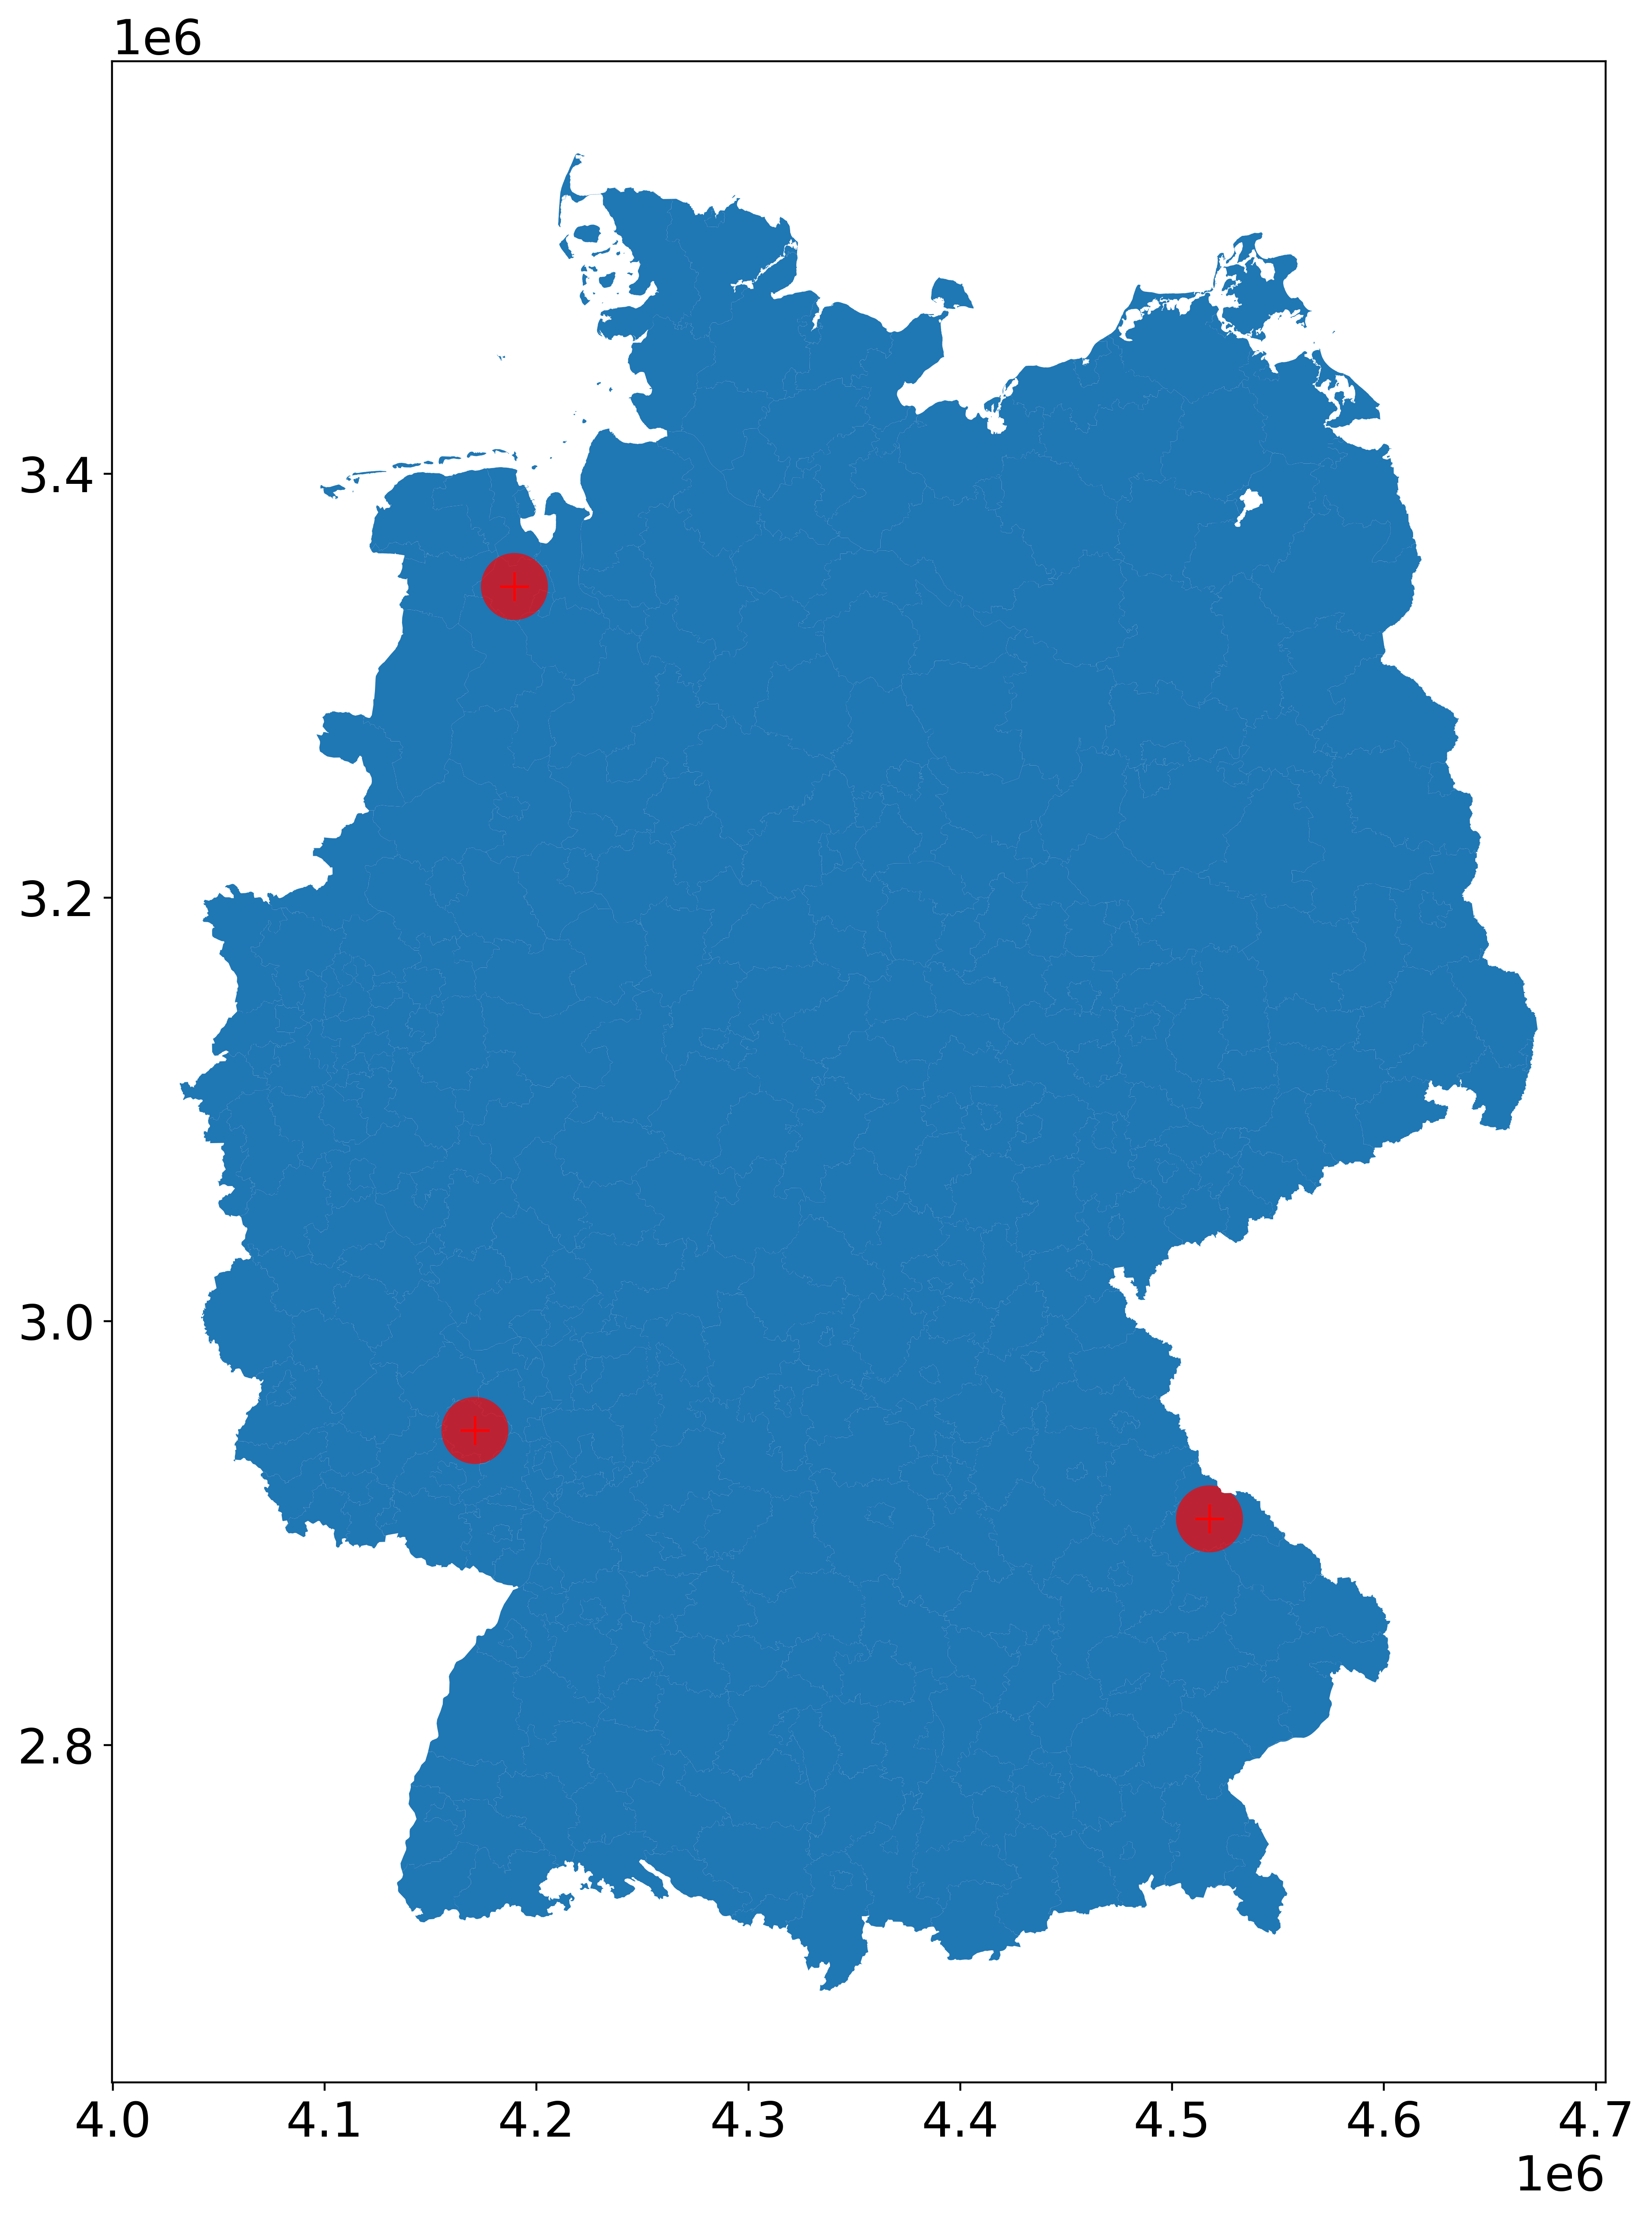

In [77]:
# convert map back to epsg:4326 such that we are able to repeatedly call this cell on its own
map = map.to_crs("epsg:4326")

# read starting points in epsg:4326
sp1 = gpd.points_from_xy(x=[map[lk_identifier[0]].centroid.x], y=[map[lk_identifier[0]].centroid.y], crs="epsg:4326")
sp2 = gpd.points_from_xy(x=[map[lk_identifier[1]].centroid.x], y=[map[lk_identifier[1]].centroid.y], crs="epsg:4326")
sp3 = gpd.points_from_xy(x=[map[lk_identifier[2]].centroid.x], y=[map[lk_identifier[2]].centroid.y], crs="epsg:4326")

sp1_3035 = sp1.to_crs('epsg:3035')
sp2_3035 = sp2.to_crs('epsg:3035')
sp3_3035 = sp3.to_crs('epsg:3035')

# now we can take the radius and project it onto the map of germany
r_m = r * 1000

# print(r_m)

# we display our map using epsg:3035 since we don't want the circles to be stretched
map = map.to_crs("epsg:3035")

# create the geometry of the radius
radius1 = sp1_3035.buffer(r * 1000, 16) # convert from km to meter
radius2 = sp2_3035.buffer(r * 1000, 16)
radius3 = sp3_3035.buffer(r * 1000, 16)

# create one big polygon of germany to intersect it with our radius
merged_map = unary_union(map)

radius1_gdf = gpd.GeoDataFrame(geometry=radius1).intersection(merged_map)
radius2_gdf = gpd.GeoDataFrame(geometry=radius2).intersection(merged_map)
radius3_gdf = gpd.GeoDataFrame(geometry=radius3).intersection(merged_map)

#radius1_gdf = radius1_gdf.to_crs("epsg:4326")
#radius2_gdf = radius2_gdf.to_crs("epsg:4326")
#radius3_gdf = radius3_gdf.to_crs("epsg:4326")

# print(radius1.intersection(map[lk_identifier[0]]))

# configure plot
plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 400

# draw plot
fig, ax = plt.subplots(1, 1,figsize=(30, 15))
map.plot(ax=ax)
radius1_gdf.plot(ax=ax, color="r", alpha=0.7)
radius2_gdf.plot(ax=ax, color="r", alpha=0.7)
radius3_gdf.plot(ax=ax, color="r", alpha=0.7)
ax.plot(sp1_3035.x, sp1_3035.y, 'r+', markersize=12)
ax.plot(sp2_3035.x, sp2_3035.y, 'r+', markersize=12)
ax.plot(sp3_3035.x, sp3_3035.y, 'r+', markersize=12)
plt.savefig("output.svg", format="svg", bbox_inches="tight")